# Photography Film Recommednation System

For this project, I wanted to create a recommendation system for film photography enthusiasts. As there are a lot of film types, I wanted to finetune a method that helps users narrow down what types of film they need for whichever purpose while considering multiple elements that might be of importance to them.  

The code I am using in this notebook is based on the [Week 3 - Content-Based Filtering](https://git.arts.ac.uk/lmccallum/personalisation-23-24/blob/main/week-3-movies.ipynb) (McCallum, 2024).

I am starting off my importing some necessary libraries:

In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns #for data visualization

pd.options.display.float_format = '{:,.2f}'.format
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity as cosine
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from IPython.display import HTML #for Image display

np.set_printoptions(threshold=np.inf)

Here, we will load and display the datasheet that we are working with. For this project, I have created my own datasheet based on the [FilmTypes website](https://www.filmtypes.com/films) (Seven Degrees Labs LLC, 2024).

In [2]:
#Read in data 
chunks = pd.read_csv("../PLI18542171_Personalization_Final Project/Data/filmtypes.csv", sep=",", chunksize=1024, index_col=0)
film = pd.DataFrame()
for chunk in chunks:
    # Process each chunk:
    film = pd.concat([film, chunk])
film

,Brand,Origin,Film type,Film formats (mm),ISO film speed,Film grain,Film contrast,Film hue,Film use cases,Description,Photo of the film,Link to the page descritpion,Film datasheet
Film name,,,,,,,,,,,,,
Adox CMS 20 II,ADOX,Belgium,Black & White,"35, 120",20,Very Fine,Very High,NaN,"Portraits, Landscape, Nature",Adox CMS 20 II is an ultra high-resolution fil...,httpsO2:P54://www.filmtypes.com/imgs/filmrolls...,https://www.filmtypes.com/films/adox-cms-20-ii,https://firebasestorage.googleapis.com/v0/b/fi...
Adox SCALA 160,ADOX,Belgium,Black & White Slide,35,160,Fine,High,NaN,"General Purpose, Portraits, Street, Landscape,...",Adox SCALA 160 is a black and white reversal f...,https://www.filmtypes.com/imgs/filmrolls/adox-...,https://www.filmtypes.com/films/adox-scala-160,https://firebasestorage.googleapis.com/v0/b/fi...
Adox SilverMax,ADOX,Belgium,Black & White,35,100,Fine,High,NaN,"General Purpose, Portraits, Street, Landscape,...",Adox SilverMax is known for its high silver co...,https://www.filmtypes.com/imgs/filmrolls/adox-...,https://www.filmtypes.com/films/adox-silvermax,https://firebasestorage.googleapis.com/v0/b/fi...
AGFA APX 100,AGFA,UK,Black & White,35,100,Fine,Medium High,NaN,"General Purpose, Portraits, Street, Landscape,...",AGFA APX 100 is a black and white film that of...,https://www.filmtypes.com/imgs/filmrolls/agfa-...,https://www.filmtypes.com/films/agfa-apx-100,https://firebasestorage.googleapis.com/v0/b/fi...
AGFA APX 400,AGFA,UK,Black & White,35,400,Medium,Medium High,NaN,"General Purpose, Portraits, Street, Sports",AGFA APX 400 is a higher-speed counterpart to ...,https://www.filmtypes.com/imgs/filmrolls/agfa-...,https://www.filmtypes.com/films/agfa-apx-400,https://firebasestorage.googleapis.com/v0/b/fi...
AGFA Vista Plus 200,AGFA,UK,Color Negative,35,200,Normal,Low Medium,Vibrant colors with a slight emphasis on reds,"General Purpose, Creative, Sunny Conditions",AGFA Vista Plus 200 is a budget-friendly color...,https://www.filmtypes.com/imgs/filmrolls/agfa-...,https://www.filmtypes.com/films/agfa-vista-plu...,https://firebasestorage.googleapis.com/v0/b/fi...
AGFA Vista Plus 400,AGFA,UK,Color Negative,35,400,Medium,Low Medium,Bright and vibrant with a warm tone,"General Purpose, Creative",AGFA Vista Plus 400 offers a higher ISO than i...,https://www.filmtypes.com/imgs/filmrolls/agfa-...,https://www.filmtypes.com/films/agfa-vista-plu...,https://firebasestorage.googleapis.com/v0/b/fi...
Cinestill 800T,Cinestill,USA,Color Negative,"35, 120",800,Medium,Low,Tungsten-balanced with warm tones,"Low Light Conditions, Tungsten, Creative",Cinestill 800T is a high-speed color negative ...,https://www.filmtypes.com/imgs/filmrolls/cines...,https://www.filmtypes.com/films/cinestill-800t,https://firebasestorage.googleapis.com/v0/b/fi...
Fomapan 100 Classic,Fomapan,Czech Republic,Black & White,"35, 120, Sheet film",100,Fine,High,NaN,"General Purpose, Portraits, Street",Fomapan 100 Classic is a traditional black and...,https://www.filmtypes.com/imgs/filmrolls/fomap...,https://www.filmtypes.com/films/fomapan-100-cl...,https://firebasestorage.googleapis.com/v0/b/fi...


## Numerical Features 

First, I want to filter films that are the most similar by numerical features - in my dataset, these are the "ISO film speed" and "Film formats (mm)" categories. 

My "Film formats (mm)" folder includes some non-numerical values, so I will start out by pre-processing the column for the ease of this analysis.

In [3]:
film['Film formats (mm)'] = film['Film formats (mm)'].astype(str)
film_formats_expanded = film['Film formats (mm)'].str.split(',', expand=True)

# Convert each column in the expanded DataFrame to numeric
for col in film_formats_expanded.columns:
    film_formats_expanded[col] = pd.to_numeric(film_formats_expanded[col], errors='coerce')

# Fill NaN values with a default value 
film_formats_expanded = film_formats_expanded.fillna(0)

# Sum the columns to combine back into a single column:
film['Film formats (mm)'] = film_formats_expanded.sum(axis=1)

# Used LLM to de-bug this
# Create a mask where all columns are zero
all_zeros_mask = (film_formats_expanded == 0).all(axis=1)
# Use this mask to drop these rows from the original 'film' DataFrame
clean_film = film[~all_zeros_mask]

Now that I have cleaned up my "Film formats (mm)" column, I can start analyzing my numerical features.

In [4]:
features = ["ISO film speed", "Film formats (mm)"]

#Get subset
subset_features =film[features].dropna()

In [5]:
#Lets look at the ranges
subset_features.describe()

,ISO film speed,Film formats (mm)
count,53.00,53.00
mean,305.38,102.92
std,244.25,60.04
min,20.00,35.00
25%,100.00,35.00
50%,200.00,155.00
75%,400.00,155.00
max,"1,000.00",155.00


In this section, we are analyzing and visualizing the similarities between different films based on their numerical features. 

In [6]:
#Standardize 
scaled_features = StandardScaler().fit_transform(subset_features)

#Extract cosine distances
numerical_similarities = cosine(scaled_features)

#Visualize 
numerical_similarities = pd.DataFrame(numerical_similarities, columns = subset_features.index, index = subset_features.index)
print(numerical_similarities)

Film name               Adox CMS 20 II  Adox SCALA 160  Adox SilverMax  \
Film name                                                                
Adox CMS 20 II                    1.00           -0.15            0.00   
Adox SCALA 160                   -0.15            1.00            0.99   
Adox SilverMax                    0.00            0.99            1.00   
AGFA APX 100                      0.00            0.99            1.00   
AGFA APX 400                     -0.82            0.69            0.57   
AGFA Vista Plus 200              -0.27            0.99            0.96   
AGFA Vista Plus 400              -0.82            0.69            0.57   
Cinestill 800T                   -0.50           -0.78           -0.86   
Fomapan 100 Classic               0.99           -0.31           -0.16   
Fomapan 200 Creative              0.89           -0.58           -0.45   
Fomapan 400 Action                0.22           -1.00           -0.98   
Fuji C200                        -0.27

In [7]:
#This part allows us to see more clearly on a gradient which films have the most similarity
numerical_similarities.iloc[:20,:20].style.background_gradient(cmap='Greens')

Film name,Adox CMS 20 II,Adox SCALA 160,Adox SilverMax,AGFA APX 100,AGFA APX 400,AGFA Vista Plus 200,AGFA Vista Plus 400,Cinestill 800T,Fomapan 100 Classic,Fomapan 200 Creative,Fomapan 400 Action,Fuji C200,Fuji Neopan 400CN,Fuji Neopan Acros 100,Fuji Pro 400H,Fuji Provia 100F,Fuji Superia 200,Fuji Superia X-TRA 400,Fuji Superia X-TRA 800,Fuji Velvia 100
Film name,,,,,,,,,,,,,,,,,,,,
Adox CMS 20 II,1.000000,-0.153589,0.000654,0.000654,-0.824031,-0.270770,-0.824031,-0.503470,0.986855,0.891279,0.216720,-0.270770,-0.824031,0.986855,0.216720,0.986855,-0.270770,-0.824031,-0.991676,0.986855
Adox SCALA 160,-0.153589,1.000000,0.988034,0.988034,0.686385,0.992809,0.686385,-0.776434,-0.311261,-0.584965,-0.997936,0.992809,0.686385,-0.311261,-0.997936,-0.311261,0.992809,0.686385,0.025081,-0.311261
Adox SilverMax,0.000654,0.988034,1.000000,1.000000,0.566006,0.962467,0.566006,-0.864342,-0.160964,-0.452872,-0.976092,0.962467,0.566006,-0.160964,-0.976092,-0.160964,0.962467,0.566006,-0.129405,-0.160964
AGFA APX 100,0.000654,0.988034,1.000000,1.000000,0.566006,0.962467,0.566006,-0.864342,-0.160964,-0.452872,-0.976092,0.962467,0.566006,-0.160964,-0.976092,-0.160964,0.962467,0.566006,-0.129405,-0.160964
AGFA APX 400,-0.824031,0.686385,0.566006,0.566006,1.000000,0.768504,1.000000,-0.074627,-0.904758,-0.991344,-0.731664,0.768504,1.000000,-0.904758,-0.731664,-0.904758,0.768504,1.000000,0.744225,-0.904758
AGFA Vista Plus 200,-0.270770,0.992809,0.962467,0.962467,0.768504,1.000000,0.768504,-0.695412,-0.422783,-0.677848,-0.998447,1.000000,0.768504,-0.422783,-0.998447,-0.422783,1.000000,0.768504,0.144570,-0.422783
AGFA Vista Plus 400,-0.824031,0.686385,0.566006,0.566006,1.000000,0.768504,1.000000,-0.074627,-0.904758,-0.991344,-0.731664,0.768504,1.000000,-0.904758,-0.731664,-0.904758,0.768504,1.000000,0.744225,-0.904758
Cinestill 800T,-0.503470,-0.776434,-0.864342,-0.864342,-0.074627,-0.695412,-0.074627,1.000000,-0.357219,-0.056941,0.734366,-0.695412,-0.074627,-0.357219,0.734366,-0.357219,-0.695412,-0.074627,0.610527,-0.357219
Fomapan 100 Classic,0.986855,-0.311261,-0.160964,-0.160964,-0.904758,-0.422783,-0.904758,-0.357219,1.000000,0.952846,0.371640,-0.422783,-0.904758,1.000000,0.371640,1.000000,-0.422783,-0.904758,-0.957832,1.000000


### Get recommendations based on a film type!

In this section, we are now able to pick the name of the photography film to get the Top N most similar based on the numerical features.

You can input your desired film for this recommendation system in the "analog =_____" cell. 

I have decided to utilize it to find films most closely associated with "Kodak Portra 400" as that is one of the few that I know of and really enjoy using. Therefore, I want to utilize this recommendation system to expand my taste and find a film that is most similar to Kodak Portra 400.

In [8]:
#Print full list of photography film names 
film.index.values

array(['Adox CMS 20 II', 'Adox SCALA 160', 'Adox SilverMax',
       'AGFA APX 100', 'AGFA APX 400', 'AGFA Vista Plus 200',
       'AGFA Vista Plus 400', 'Cinestill 800T', 'Fomapan 100 Classic',
       'Fomapan 200 Creative', 'Fomapan 400 Action', 'Fuji C200',
       'Fuji Neopan 400CN', 'Fuji Neopan Acros 100', 'Fuji Pro 400H',
       'Fuji Provia 100F', 'Fuji Superia 200', 'Fuji Superia X-TRA 400',
       'Fuji Superia X-TRA 800', 'Fuji Velvia 100', 'Fuji Velvia 50',
       'Ilford Delta 100', 'Ilford Delta 3200', 'Ilford Delta 400',
       'Ilford FP4 Plus', 'Ilford HP5 Plus', 'Ilford Pan 100',
       'Ilford Pan 400', 'Ilford Pan F Plus', 'Ilford SFX 200',
       'Ilford XP2 Super', 'Kentmere 100', 'Kentmere 400',
       'Kodak ColorPlus 200', 'Kodak Ektachrome E100', 'Kodak Ektar 100',
       'Kodak Gold 200', 'Kodak Portra 160', 'Kodak Portra 400',
       'Kodak Portra 800', 'Kodak ProImage 100', 'Kodak T-MAX 100',
       'Kodak T-MAX 400', 'Kodak T-MAX P3200', 'Kodak Tri-X 400',


In [9]:
#Input any of the film names above
analog = "Kodak Portra 400"

In [10]:
# Select the number of suggestions
n = 10

In [11]:
#List top 10 film analog similarities for this type of film
numerical_similarities.sort_values(by = analog, ascending=False)[film].index[1:n+1]

Index(['Fomapan 400 Action', 'Lomography Lady Grey', 'Ilford XP2 Super',
       'Kodak Tri-X 400', 'Ilford HP5 Plus', 'Kodak T-MAX 400',
       'Ilford Delta 400', 'Kodak Portra 400', 'Retro Pan 320 Soft',
       'Kodak Portra 800'],
      dtype='object', name='Film name')

Here, the recommendations will be displayed in a more readable way, along with additional information that the user can read about. 

In [12]:
numerical_recommendations = film.loc[numerical_similarities.sort_values(by=analog, ascending=False).index[1:n+1]]
df_numerical_recommendations = numerical_recommendations.copy()
df_numerical_recommendations.reset_index(inplace=True)

print(df_numerical_recommendations.to_string(index=False))

#Used LLM to help display the images
HTML(''.join(f'<img src="{url}" style="width:100px; display:inline-block; margin:10px"/>' for url in df_numerical_recommendations['Photo of the film']))

           Film name      Brand         Origin       Film type  Film formats (mm)  ISO film speed Film grain Film contrast                                       Film hue                                                   Film use cases                                                                                                                                                                                                                                                                                                                                                                                                                             Description                                                 Photo of the film                         Link to the page descritpion                                                                                                                                                        Film datasheet
  Fomapan 400 Action    Fomapan Czech Republic   Black &

### Conclusion on Numerical Analysis 

In this analysis, I can see that the recommendation worked - as it suggested films that have the same ISO as Kodak Portra 400, as well as film formats of 155 mm (which means that like Kodak Portra 400, which comes in both 35 and 120 mm, and were summed together for the purpose of this analysis).

Here are the top numeric recommendations: 

1. **Fomapan 400 Action**
2. **Lomography Lady Grey**
3. **Ilford XP2 Super**
4. **Kodak Tri-X 400**
5. **Ilford HP5 Plus**
6. **Kodak T-MAX 400**
7. **Ilford Delta 400**
8. **Kodak Portra 400**
9. **Retro Pan 320 Soft**
10. **Kodak Portra 800**


## Categorical Data 

Most of my datasheet isn't numerical; therefore, some transformations needed to be applied for these categories. 

### One hot encoding 

To split data that is comma-separated, we can utilize one-hot encoding by replacing it with a new column for each unique value. The feature will be 1 if the film has that value, 0 otherwise.

In this section, we will be focusing on the "Film_use_cases" column, as it lists various types of film uses.

In [13]:
print(film.columns)
print(film.dtypes)

Index(['Brand', 'Origin', 'Film type', 'Film formats (mm)', 'ISO film speed',
       'Film grain', 'Film contrast', 'Film hue', 'Film use cases',
       'Description', 'Photo of the film', 'Link to the page descritpion',
       'Film datasheet'],
      dtype='object')
Brand                            object
Origin                           object
Film type                        object
Film formats (mm)               float64
ISO film speed                    int64
Film grain                       object
Film contrast                    object
Film hue                         object
Film use cases                   object
Description                      object
Photo of the film                object
Link to the page descritpion     object
Film datasheet                   object
dtype: object


In [14]:
df_exploded = film.assign(Film_use_cases=film['Film use cases'].str.split(',')).explode('Film use cases')
df_encoded = pd.get_dummies(df_exploded, columns=['Film use cases'])
one_hot_films = df_encoded.groupby('Film name').sum().reset_index()
one_hot_films.index = one_hot_films['Film name'].values

In [15]:
one_hot_films

,Film name,Brand,Origin,Film type,Film formats (mm),ISO film speed,Film grain,Film contrast,Film hue,Description,...,"Film use cases_Nature, Travel, Fashion, Landscape","Film use cases_Portraits, General Purpose, Product","Film use cases_Portraits, Landscape, Nature","Film use cases_Portraits, Wedding, General Purpose, Fashion","Film use cases_Sunny Conditions, General Purpose","Film use cases_Sunny Conditions, Sports, Low Light Conditions","Film use cases_Wedding, Fashion, Portraits, Sport","Film use cases_Wedding, Portraits, General Purpose","Film use cases_Wedding, Portraits, General Purpose, Sports","Film use cases_Wedding, Street, Sports"
AGFA APX 100,AGFA APX 100,AGFA,UK,Black & White,35.00,100,Fine,Medium High,0,AGFA APX 100 is a black and white film that of...,...,0,0,0,0,0,0,0,0,0,0
AGFA APX 400,AGFA APX 400,AGFA,UK,Black & White,35.00,400,Medium,Medium High,0,AGFA APX 400 is a higher-speed counterpart to ...,...,0,0,0,0,0,0,0,0,0,0
AGFA Vista Plus 200,AGFA Vista Plus 200,AGFA,UK,Color Negative,35.00,200,Normal,Low Medium,Vibrant colors with a slight emphasis on reds,AGFA Vista Plus 200 is a budget-friendly color...,...,0,0,0,0,0,0,0,0,0,0
AGFA Vista Plus 400,AGFA Vista Plus 400,AGFA,UK,Color Negative,35.00,400,Medium,Low Medium,Bright and vibrant with a warm tone,AGFA Vista Plus 400 offers a higher ISO than i...,...,0,0,0,0,0,0,0,0,0,0
Adox CMS 20 II,Adox CMS 20 II,ADOX,Belgium,Black & White,155.00,20,Very Fine,Very High,0,Adox CMS 20 II is an ultra high-resolution fil...,...,0,0,1,0,0,0,0,0,0,0
Adox SCALA 160,Adox SCALA 160,ADOX,Belgium,Black & White Slide,35.00,160,Fine,High,0,Adox SCALA 160 is a black and white reversal f...,...,0,0,0,0,0,0,0,0,0,0
Adox SilverMax,Adox SilverMax,ADOX,Belgium,Black & White,35.00,100,Fine,High,0,Adox SilverMax is known for its high silver co...,...,0,0,0,0,0,0,0,0,0,0
Cinestill 800T,Cinestill 800T,Cinestill,USA,Color Negative,155.00,800,Medium,Low,Tungsten-balanced with warm tones,Cinestill 800T is a high-speed color negative ...,...,0,0,0,0,0,0,0,0,0,0
Fomapan 100 Classic,Fomapan 100 Classic,Fomapan,Czech Republic,Black & White,155.00,100,Fine,High,0,Fomapan 100 Classic is a traditional black and...,...,0,0,0,0,0,0,0,0,0,0
Fomapan 200 Creative,Fomapan 200 Creative,Fomapan,Czech Republic,Black & White,155.00,200,Normal,Medium,0,Fomapan 200 Creative is slightly faster than t...,...,0,0,0,0,0,0,0,0,0,0


In [16]:
#See all the new columns and their feature names
film_use_features = [col for col in one_hot_films.columns if 'Film use cases' in col]
film_use_features

['Film use cases_Creative',
 'Film use cases_Creative, Street, Landscape, Nature, Fashion',
 'Film use cases_Fashion, Wedding, Portraits',
 'Film use cases_General Purpose',
 'Film use cases_General Purpose, Creative',
 'Film use cases_General Purpose, Creative, Sunny Conditions',
 'Film use cases_General Purpose, Detailed Subject, Product',
 'Film use cases_General Purpose, Detailed Subject, Sports',
 'Film use cases_General Purpose, Low Light Conditions',
 'Film use cases_General Purpose, Portraits',
 'Film use cases_General Purpose, Portraits, Sports',
 'Film use cases_General Purpose, Portraits, Street',
 'Film use cases_General Purpose, Portraits, Street, Landscape, Nature',
 'Film use cases_General Purpose, Portraits, Street, Landscape, Nature, Creative',
 'Film use cases_General Purpose, Portraits, Street, Sports',
 'Film use cases_General Purpose, Portraits, Street, Sports, Low Light Conditions',
 'Film use cases_General Purpose, Portraits, Street, Travel, Sports',
 'Film use c

In [17]:
one_hot_films.loc[analog]

Film name                                                                                                           Kodak Portra 400
Brand                                                                                                                          Kodak
Origin                                                                                                                           USA
Film type                                                                                                            Color Negative 
Film formats (mm)                                                                                                             155.00
ISO film speed                                                                                                                   400
Film grain                                                                                                                      Fine
Film contrast                                                        

As we can see in this output, it classified Kodak Portra 400 for the purposes of "Portraits, General Purpose, Product," which is what I have listed in my datasheet.                                                                                

### Get some recommendations 

Here we go through the same process, but instead of using the numerical features, we use the one hot encoded film use columns.

In [18]:
#Get cosine distances
film_use_subset_features = one_hot_films[film_use_features]
film_use_similarities = cosine(film_use_subset_features)

#Visualize 
film_use_similarities = pd.DataFrame(film_use_similarities, columns = film.index, index = film.index)
print(film_use_similarities)

Film name               Adox CMS 20 II  Adox SCALA 160  Adox SilverMax  \
Film name                                                                
Adox CMS 20 II                    1.00            0.00            0.00   
Adox SCALA 160                    0.00            1.00            0.00   
Adox SilverMax                    0.00            0.00            1.00   
AGFA APX 100                      0.00            0.00            0.00   
AGFA APX 400                      0.00            0.00            0.00   
AGFA Vista Plus 200               1.00            0.00            0.00   
AGFA Vista Plus 400               1.00            0.00            0.00   
Cinestill 800T                    0.00            0.00            0.00   
Fomapan 100 Classic               0.00            0.00            0.00   
Fomapan 200 Creative              0.00            0.00            0.00   
Fomapan 400 Action                0.00            0.00            0.00   
Fuji C200                         0.00

In [19]:
#Similarities

#I have also added a background gradient to interpret the results better
film_use_similarities.iloc[:20,:20].style.background_gradient(cmap='Greens')

Film name,Adox CMS 20 II,Adox SCALA 160,Adox SilverMax,AGFA APX 100,AGFA APX 400,AGFA Vista Plus 200,AGFA Vista Plus 400,Cinestill 800T,Fomapan 100 Classic,Fomapan 200 Creative,Fomapan 400 Action,Fuji C200,Fuji Neopan 400CN,Fuji Neopan Acros 100,Fuji Pro 400H,Fuji Provia 100F,Fuji Superia 200,Fuji Superia X-TRA 400,Fuji Superia X-TRA 800,Fuji Velvia 100
Film name,,,,,,,,,,,,,,,,,,,,
Adox CMS 20 II,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Adox SCALA 160,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Adox SilverMax,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AGFA APX 100,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AGFA APX 400,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AGFA Vista Plus 200,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AGFA Vista Plus 400,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Cinestill 800T,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Fomapan 100 Classic,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [20]:
sorted = film_use_similarities.sort_values(by = analog, ascending=False)
#Get top n (excluding 1 because thats the exact match / same film)
film_use_top_n = sorted[film].index[1:n+1].values
film_use_top_n

array(['Adox CMS 20 II', 'Ilford Pan 400', 'Ilford SFX 200',
       'Ilford XP2 Super', 'Kentmere 100', 'Kentmere 400',
       'Kodak ColorPlus 200', 'Kodak Ektachrome E100', 'Kodak Ektar 100',
       'Kodak Gold 200'], dtype=object)

In [21]:
#Print film use cases for top film analogs
print(film_use_features)
[list(subset_features.loc[i].values) for i in film_use_top_n]

['Film use cases_Creative', 'Film use cases_Creative, Street, Landscape, Nature, Fashion', 'Film use cases_Fashion, Wedding, Portraits', 'Film use cases_General Purpose', 'Film use cases_General Purpose, Creative', 'Film use cases_General Purpose, Creative, Sunny Conditions', 'Film use cases_General Purpose, Detailed Subject, Product', 'Film use cases_General Purpose, Detailed Subject, Sports', 'Film use cases_General Purpose, Low Light Conditions', 'Film use cases_General Purpose, Portraits', 'Film use cases_General Purpose, Portraits, Sports', 'Film use cases_General Purpose, Portraits, Street', 'Film use cases_General Purpose, Portraits, Street, Landscape, Nature', 'Film use cases_General Purpose, Portraits, Street, Landscape, Nature, Creative', 'Film use cases_General Purpose, Portraits, Street, Sports', 'Film use cases_General Purpose, Portraits, Street, Sports, Low Light Conditions', 'Film use cases_General Purpose, Portraits, Street, Travel, Sports', 'Film use cases_General Purp

[[20.0, 155.0],
 [400.0, 35.0],
 [200.0, 155.0],
 [400.0, 155.0],
 [100.0, 35.0],
 [400.0, 35.0],
 [200.0, 35.0],
 [100.0, 155.0],
 [100.0, 155.0],
 [200.0, 35.0]]

Here, I want to display it in a pandas dataframe, so its easier to read and cross-reference to other features of these recommendaitons.

In [22]:
film_use_cases_recommendations = film.loc[film_use_top_n]
df_film_use_cases_recommendations = film_use_cases_recommendations.copy()
df_film_use_cases_recommendations.reset_index(inplace=True)
print(df_film_use_cases_recommendations.to_string(index=False))

HTML(''.join(f'<img src="{url}" style="width:100px; display:inline-block; margin:10px"/>' for url in df_film_use_cases_recommendations['Photo of the film']))
# Used LLM to help display the images

            Film name    Brand  Origin       Film type  Film formats (mm)  ISO film speed Film grain Film contrast                                Film hue                               Film use cases                                                                                                                                                                                                                                                                                                                                                                                 Description                                                  Photo of the film                          Link to the page descritpion                                                                                                                                                Film datasheet
       Adox CMS 20 II     ADOX Belgium   Black & White             155.00              20  Very Fine    Very High                            

### Conclusion on One-Hot Encoding Analysis 

1. **Adox CMS 20 II**
2. **Ilford Pan 400**
3. **Ilford SFX 200**
4. **Ilford XP2 Super**
5. **Kentmere 100**
6. **Kentmere 400**
7. **Kodak ColorPlus 200**
8. **Kodak Ektachrome E100**
9. **Kodak Ektar 100**
10. **Kodak Gold 200**

This recommendation system, unfortunately, was not as effective in this analysis in comparison to the numeric one. Due to the fact that there were multiple attributes that were assigned to each film type for their "uses," they all produced unique combinations that sometimes did not align. Kodak Portra 400 has film use purposes such as Portraits, General Purpose, and Product - only 7 of the recommended films had one or two overlaps, yet no exact match. This means that even though there might be films that have all three of those attributes, the system didn't take them into account, like, for example, the Fuji Provia 100F - which has all of those film use cases. 

However, if we check the matrix above, for other film analog types, such as AGFA Vista Plus 200, it did find an exact match to AGFA Vista Plus 400. 

If I were to improve this categorical recommendation system in order to optimize these results, perhaps I could try embedding the data in order to reduce the dimensionality and represent the categories better.

### Bag of Words

In general, I would like to explore the "Film type", "Film grain", "Film contrast", "Film hue", "Film use cases" categories. As a new user, I was quite oblivious to the numerical features since I didn't have an understanding of its context, so textual descriptors of the desired results could be better suited in this case. 

Therefore, adopting an approach such as "Bag of Words" can be quite useful for my recommendation system. 

In [23]:
# Making a tags column that concatenates all the categories including "Film use cases"

def get_tags(x):
    return str(x['Film hue']) + ' ' + str(x['Film contrast']) + ' ' + str(x['Film type']) + ' ' + str(x['Film grain']) + ' ' + str(x['Film use cases'])

film['tags'] = film.apply(get_tags, axis=1)

In [24]:
#Count occurences of each word in each film analog

count = CountVectorizer()
count_matrix = count.fit_transform(film['tags'])
count_matrix.shape

(53, 82)

In [25]:
#Let's see the unique tokens 

vocab = count.get_feature_names_out()
vocab, len(vocab)

(array(['and', 'balance', 'balanced', 'bias', 'black', 'blue', 'bright',
        'cast', 'color', 'colors', 'conditions', 'creative', 'detailed',
        'emphasis', 'fashion', 'film', 'fine', 'for', 'general', 'good',
        'green', 'high', 'highly', 'hint', 'hue', 'landscape', 'light',
        'lomochrome', 'low', 'magenta', 'medium', 'muted', 'nan',
        'natural', 'nature', 'negative', 'neutral', 'normal', 'of', 'on',
        'pleasing', 'portraits', 'product', 'purple', 'purpose', 'red',
        'reds', 'rendering', 'rendition', 'reproduction', 'rich',
        'saturated', 'saturation', 'shifts', 'skin', 'slide', 'slight',
        'slightly', 'sport', 'sports', 'street', 'strong', 'subject',
        'sunny', 'tinges', 'to', 'tone', 'tones', 'touch', 'travel',
        'tungsten', 'very', 'vibrant', 'vintage', 'vivid', 'warm',
        'warmer', 'warmth', 'wedding', 'white', 'with', 'xr'], dtype=object),
 82)

### Get Recommendations 


In [26]:
#Get similarity 

bof_similarities = cosine(count_matrix)
bof_similarities = pd.DataFrame(bof_similarities, columns = film.index, index = film.index)
bof_similarities.iloc[:20,:20].style.background_gradient(cmap='Greens')

Film name,Adox CMS 20 II,Adox SCALA 160,Adox SilverMax,AGFA APX 100,AGFA APX 400,AGFA Vista Plus 200,AGFA Vista Plus 400,Cinestill 800T,Fomapan 100 Classic,Fomapan 200 Creative,Fomapan 400 Action,Fuji C200,Fuji Neopan 400CN,Fuji Neopan Acros 100,Fuji Pro 400H,Fuji Provia 100F,Fuji Superia 200,Fuji Superia X-TRA 400,Fuji Superia X-TRA 800,Fuji Velvia 100
Film name,,,,,,,,,,,,,,,,,,,,
Adox CMS 20 II,1.000000,0.666667,0.696311,0.666667,0.400320,0.000000,0.000000,0.000000,0.577350,0.384900,0.320256,0.000000,0.522233,0.547723,0.068041,0.397360,0.000000,0.000000,0.000000,0.462910
Adox SCALA 160,0.666667,1.000000,0.957427,0.916667,0.640513,0.140028,0.144338,0.000000,0.866025,0.673575,0.560449,0.140028,0.696311,0.730297,0.068041,0.463586,0.154303,0.132453,0.129099,0.385758
Adox SilverMax,0.696311,0.957427,1.000000,0.957427,0.668994,0.146254,0.150756,0.000000,0.904534,0.703526,0.585369,0.146254,0.727273,0.762770,0.071067,0.415029,0.161165,0.138343,0.134840,0.322329
AGFA APX 100,0.666667,0.916667,0.957427,1.000000,0.800641,0.210042,0.288675,0.068041,0.866025,0.769800,0.640513,0.210042,0.783349,0.821584,0.136083,0.463586,0.231455,0.198680,0.258199,0.308607
AGFA APX 400,0.400320,0.640513,0.668994,0.800641,1.000000,0.269069,0.416025,0.130744,0.739600,0.832050,0.769231,0.269069,0.836242,0.789352,0.196116,0.381771,0.296500,0.318142,0.434122,0.074125
AGFA Vista Plus 200,0.000000,0.140028,0.146254,0.210042,0.269069,1.000000,0.606339,0.457330,0.161690,0.323381,0.403604,0.470588,0.219382,0.230089,0.400163,0.278207,0.518563,0.667698,0.488094,0.259281
AGFA Vista Plus 400,0.000000,0.144338,0.150756,0.288675,0.416025,0.606339,1.000000,0.530330,0.166667,0.333333,0.346688,0.545705,0.301511,0.316228,0.353553,0.401478,0.534522,0.516185,0.670820,0.200446
Cinestill 800T,0.000000,0.000000,0.000000,0.068041,0.130744,0.457330,0.530330,1.000000,0.000000,0.078567,0.326860,0.514496,0.071067,0.074536,0.388889,0.162221,0.251976,0.486664,0.579751,0.125988
Fomapan 100 Classic,0.577350,0.866025,0.904534,0.866025,0.739600,0.161690,0.166667,0.000000,1.000000,0.777778,0.647150,0.161690,0.804030,0.843274,0.078567,0.382360,0.178174,0.152944,0.149071,0.178174


In [27]:
#Here we are looking at the percentage of non-zero entries in a similarty matrix
total_cells = bof_similarities.shape[0]*bof_similarities.shape[1]
non_zero = bof_similarities.ne(0).sum().sum()
percentage_non_zero = non_zero/total_cells*100
percentage_non_zero

94.94482022071912

The output of 95% for Kodak Portra 400 tells us that there is a high percentage of film pairs that have some level of similarity. For my purpose of finding films that share these similarities this is a good sign, as I can explore more options in my search for a good alternative. 

In [28]:
bof_sorted = bof_similarities.sort_values(by = analog, ascending = False)
bof_top_n = bof_sorted[analog][0:n+1].index
bof_top_n

Index(['Kodak Portra 400', 'Fuji Superia X-TRA 400', 'Kodak ProImage 100',
       'Lomography CN 100', 'Kodak Ultramax 400', 'Kodak ColorPlus 200',
       'Lomography CN 400', 'AGFA Vista Plus 200', 'Kodak Portra 160',
       'Kodak Gold 200', 'Fuji Provia 100F'],
      dtype='object', name='Film name')

Here, I am displaying this information in a pandas data frame, so once again, the user can cross-check it if they would like with other features but can still see the tags we have included:

In [29]:
bof_similarity_recommendations = film.loc[bof_top_n]
df_bof_similarity_recommendations = bof_similarity_recommendations.copy()
df_bof_similarity_recommendations.reset_index(inplace=True)
print(df_bof_similarity_recommendations.to_string(index=False))

HTML(''.join(f'<img src="{url}" style="width:100px; display:inline-block; margin:10px"/>' for url in df_bof_similarity_recommendations['Photo of the film']))

             Film name      Brand Origin       Film type  Film formats (mm)  ISO film speed Film grain Film contrast                                                          Film hue                                          Film use cases                                                                                                                                                                                                                                                                                                                                                                                       Description                                                   Photo of the film                           Link to the page descritpion                                                                                                                                               Film datasheet                                                                                                

### Conclusion on BOF

These are the outputs for the BOF recommendations: 

1. **Fuji Superia X-TRA 400**
2. **Kodak ProImage 100**
3. **Lomography CN 100**
4. **Kodak Ultramax 400**
5. **Kodak ColorPlus 200**
6. **Lomography CN 400**
7. **AGFA Vista Plus 200**
8. **Kodak Portra 160**
9. **Kodak Gold 200**
10. **Fuji Provia 100F**

Assessing these options, I can see a lot of overlap and similarities to the Kodak Portra 400. Almost all of them are the "color negative" type, close to a "medium-high" contrast, natural hues, and share at least one similarity of film use cases. 

Nevertheless, there were some suggestions that weren't ideally matched, as there were not a lot of top suggestions with a "Fine" grain like in Portra 400. However, I believe that is due to the other factors matching better in terms of vocabulary. Additionally, this recommendation approach did not take into account ISO and film formats (as they are numerical values), which also has an impact of the hue that is produced. 

### Playing around with topic modeling

For my own curiosity, I wanted to see how the application of topic modeling could be impactful in any way for this dataset.  

The code that I have used for topic modeling is based on the project I have done for the Natural Language Processing for the Creative Industries module - specifically based on the Week 4 LDA modeling notebook (Broad & Fiebrink, 2023).

In [30]:
#importing necessary libraries
import os
import nltk
import pandas as pd

from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

I am downloading a library of English stop words and the semantic word database [wordnet](https://wordnet.princeton.edu/https://wordnet.princeton.edu/) that will be utilized for lemmatization. 

In [31]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/oksanapliushko/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/oksanapliushko/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/oksanapliushko/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

First we need to define this function which gets us the [Part of Speech tag](https://en.wikipedia.org/wiki/Part-of-speech_tagging) (POS), to tell us what type of word each word in our dataset is.

In [32]:
# Function originally from: https://www.programcreek.com/python/?CodeExample=get%20wordnet%20pos
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    
    # Return the tag, if the tag is not found return noun. 
    return tag_dict.get(tag, wordnet.NOUN)

In [33]:
#Pre-processing my data
def preprocess_text(text):

    # Convert to lowercase
    text = text.lower()

    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenize the text
    tokens = text.split()

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatize the words
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

In [34]:
# Now, I am going to use `CountVectorizer` class to get the bag of words features for the document.
from sklearn.feature_extraction.text import CountVectorizer

film['tags'] = film['tags'].fillna('')

# Create an instance of CountVectorizer with specified stop words and ngram range
vectorizer = CountVectorizer(stop_words='english', ngram_range=(1, 7))

# Fit and transform the 'tags' column to get the bag of words features
bag_of_words = vectorizer.fit_transform(film['tags'])

# Get the vocabulary of the features
vocab = vectorizer.get_feature_names_out()

# Print the shape and size of the bag of words matrix
print(f'Our bag of words is a matrix of the shape and size {bag_of_words.shape}')

Our bag of words is a matrix of the shape and size (53, 1427)


In [35]:
# Apply LDA for topic modeling
num_topics = 10  
pd.options.display.max_columns=num_topics

In [36]:
num_topics = 13
pd.options.display.max_columns=num_topics 
labels = ['topic{}'.format(i) for i in range(num_topics)]

In [37]:
#In here, the Latent Dirichlet Allocation (LDA) algorithm will be defined:
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42, learning_method='batch')

In [38]:
#Fitting the LDA model
lda_topics = lda.fit_transform(bag_of_words)

In [39]:
#Here, we can see some of the weightings between our topics and our words:
topic_weights = pd.DataFrame(lda.components_.T, index=vocab, columns=labels)
topic_weights.head(13)

,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,topic10,topic11,topic12
balance,0.08,0.08,0.08,0.08,0.08,0.08,0.08,0.08,0.08,0.08,1.08,0.08,0.08
balance medium,0.08,0.08,0.08,0.08,0.08,0.08,0.08,0.08,0.08,0.08,1.08,0.08,0.08
balance medium high,0.08,0.08,0.08,0.08,0.08,0.08,0.08,0.08,0.08,0.08,1.08,0.08,0.08
balance medium high color,0.08,0.08,0.08,0.08,0.08,0.08,0.08,0.08,0.08,0.08,1.08,0.08,0.08
balance medium high color slide,0.08,0.08,0.08,0.08,0.08,0.08,0.08,0.08,0.08,0.08,1.08,0.08,0.08
balance medium high color slide fine,0.08,0.08,0.08,0.08,0.08,0.08,0.08,0.08,0.08,0.08,1.08,0.08,0.08
balance medium high color slide fine nature,0.08,0.08,0.08,0.08,0.08,0.08,0.08,0.08,0.08,0.08,1.08,0.08,0.08
balanced,1.08,0.08,0.08,1.08,0.08,0.08,0.08,0.08,1.08,0.08,0.08,0.08,0.08
balanced color,0.08,0.08,0.08,1.08,0.08,0.08,0.08,0.08,0.08,0.08,0.08,0.08,0.08
balanced color reproduction,0.08,0.08,0.08,1.08,0.08,0.08,0.08,0.08,0.08,0.08,0.08,0.08,0.08


Here are most relevant words for each topic!

In [40]:
num_terms = 13
for i in range(num_topics):
    print("___topic " + str(i) + "___")
    topicName = "topic" + str(i)
    weightedlist = topic_weights.get(topicName).sort_values()[-num_terms:]
    print(weightedlist.index.values)

___topic 0___
['tones' 'color' 'negative medium' 'color negative medium'
 'light conditions' 'low light' 'low light conditions' 'light'
 'color negative' 'negative' 'conditions' 'medium' 'low']
___topic 1___
['low light' 'low light conditions' 'low' 'nan' 'black' 'black white'
 'white' 'high black white' 'high black' 'nan high' 'nan high black white'
 'nan high black' 'high']
___topic 2___
['creative sunny' 'vibrant colors' 'vibrant colors slight emphasis reds'
 'colors slight emphasis reds low medium'
 'colors slight emphasis reds low medium color' 'general purpose creative'
 'purpose creative' 'colors' 'sunny conditions' 'sunny' 'conditions'
 'creative' 'reds']
___topic 3___
['low medium color' 'low medium' 'low' 'purpose' 'general purpose'
 'general' 'tones' 'medium color negative' 'medium color' 'medium'
 'negative' 'color negative' 'color']
___topic 4___
['portraits' 'tones' 'color negative' 'negative' 'medium high color'
 'high color' 'high' 'medium high' 'purpose' 'general purpo

In [41]:
lda_topic_vectors_df = pd.DataFrame(lda_topics, index=film.index, columns=['topic{}'.format(i) for i in range(13)])

In [42]:
#Here we sort the importance and try to see the correspondence between the most important words in the topic
lda_topic_vectors_df.sort_values(by=['topic1'], ascending=False)

,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,topic10,topic11,topic12
Film name,,,,,,,,,,,,,
Ilford Delta 3200,0.00,0.98,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Kodak T-MAX P3200,0.00,0.98,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Kodak Portra 800,0.00,0.98,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Adox CMS 20 II,0.00,0.97,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Ilford Pan F Plus,0.00,0.97,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Ilford FP4 Plus,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.97
Lomography Earl Grey,0.00,0.00,0.00,0.00,0.00,0.00,0.22,0.00,0.00,0.00,0.00,0.00,0.75
Lomography Lady Grey,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.58,0.00,0.39
Kodak Tri-X 400,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.47,0.00,0.51


It's interesting to see the correlations between these topics and the various film types. For example, lford Delta 3200 has a high value (0.98) in topic 1 - which includes the following keywords: 
['low light' 'low light conditions' 'low' 'nan' 'black' 'black white'
 'white' 'high black white' 'high black' 'nan high' 'nan high black white'
 'nan high black' 'high'].

In the datasheet, the Ilford Delta 3200 has a lot of these attributes - such as a black and white" film type that is suitable for low light conditions. This means that if a user were to input any of these attributes in their keyword search, Ilford Delta 3200 would most likely pop up in the suggestions first. 

### Conclusion on LDA Topic Modeling 

Topic modeling analysis of my own dataset can be useful in order to provide keyword suggestions for users in my "interactive chat" that you will be able to explore in the "Interactive_Film_Recommendation_Chat" notebook, as well as seeing words that repeat the most, and perhaps help me optimize my datasheet for further analysis.

From this analysis, I can see that in the future, I can filter out words such as "nan" that could be hiding other important topics. It also provided some descriptors that I can suggest for people to use in the chatbot, like searching for keywords such as "vibrant" and "warm."

## Unstructured Text 

We can also turn more open, unstructured text into vectors using TFIDF. This splits them into tokens and gives each token for its importance within that overview. 

Here, we are looking at the 'Description' column more closely, as it is more unstructured than my other columns.

In [43]:
#Make vectorizer 
tfidf = TfidfVectorizer(stop_words='english')
film['Description'] = film['Description'].fillna('')

#Transform overview column into TFIDF vectors
tfidf_matrix = tfidf.fit_transform(film['Description'])
tfidf_matrix.shape

(53, 458)

In [44]:
#Unique tokens 
vocab = count.get_feature_names_out()
vocab, len(vocab)

(array(['and', 'balance', 'balanced', 'bias', 'black', 'blue', 'bright',
        'cast', 'color', 'colors', 'conditions', 'creative', 'detailed',
        'emphasis', 'fashion', 'film', 'fine', 'for', 'general', 'good',
        'green', 'high', 'highly', 'hint', 'hue', 'landscape', 'light',
        'lomochrome', 'low', 'magenta', 'medium', 'muted', 'nan',
        'natural', 'nature', 'negative', 'neutral', 'normal', 'of', 'on',
        'pleasing', 'portraits', 'product', 'purple', 'purpose', 'red',
        'reds', 'rendering', 'rendition', 'reproduction', 'rich',
        'saturated', 'saturation', 'shifts', 'skin', 'slide', 'slight',
        'slightly', 'sport', 'sports', 'street', 'strong', 'subject',
        'sunny', 'tinges', 'to', 'tone', 'tones', 'touch', 'travel',
        'tungsten', 'very', 'vibrant', 'vintage', 'vivid', 'warm',
        'warmer', 'warmth', 'wedding', 'white', 'with', 'xr'], dtype=object),
 82)

### Get Recommendations

As with all the other methods, we can now use cosine similarity, sort and get some recommendations of films that are similar **based on the vector representation of their overviews**. I have also added shading to the background, to see the distinction a bit more clearly.

In [45]:
description_similarities = cosine(tfidf_matrix)
description_similarities = pd.DataFrame(description_similarities, columns = film.index, index = film.index)
description_similarities.iloc[:20,:20].style.background_gradient(cmap='Greens')

Film name,Adox CMS 20 II,Adox SCALA 160,Adox SilverMax,AGFA APX 100,AGFA APX 400,AGFA Vista Plus 200,AGFA Vista Plus 400,Cinestill 800T,Fomapan 100 Classic,Fomapan 200 Creative,Fomapan 400 Action,Fuji C200,Fuji Neopan 400CN,Fuji Neopan Acros 100,Fuji Pro 400H,Fuji Provia 100F,Fuji Superia 200,Fuji Superia X-TRA 400,Fuji Superia X-TRA 800,Fuji Velvia 100
Film name,,,,,,,,,,,,,,,,,,,,
Adox CMS 20 II,1.000000,0.091254,0.234546,0.083792,0.049327,0.042723,0.030354,0.043939,0.056500,0.025808,0.081815,0.034574,0.087885,0.107603,0.066004,0.060662,0.011389,0.087444,0.141202,0.100305
Adox SCALA 160,0.091254,1.000000,0.175453,0.166657,0.041504,0.075629,0.039070,0.042575,0.149525,0.121423,0.110278,0.072762,0.293119,0.027190,0.038514,0.101215,0.017643,0.058915,0.038897,0.068356
Adox SilverMax,0.234546,0.175453,1.000000,0.217471,0.032080,0.030164,0.011106,0.039822,0.248031,0.157390,0.127153,0.080534,0.142118,0.084670,0.039600,0.080682,0.004130,0.041738,0.083972,0.068152
AGFA APX 100,0.083792,0.166657,0.217471,1.000000,0.276314,0.176409,0.242925,0.046564,0.135026,0.072319,0.101786,0.179765,0.164062,0.167691,0.071643,0.035266,0.060031,0.135710,0.099127,0.097721
AGFA APX 400,0.049327,0.041504,0.032080,0.276314,1.000000,0.109744,0.370016,0.113818,0.080067,0.065381,0.090381,0.050063,0.013783,0.054540,0.103208,0.023837,0.038195,0.196444,0.121377,0.048810
AGFA Vista Plus 200,0.042723,0.075629,0.030164,0.176409,0.109744,1.000000,0.270880,0.053512,0.116240,0.093988,0.049441,0.272937,0.113418,0.029680,0.134821,0.113145,0.173708,0.089206,0.068703,0.197344
AGFA Vista Plus 400,0.030354,0.039070,0.011106,0.242925,0.370016,0.270880,1.000000,0.066258,0.029202,0.127368,0.170796,0.174387,0.049900,0.036998,0.139808,0.056145,0.137650,0.218471,0.280777,0.031201
Cinestill 800T,0.043939,0.042575,0.039822,0.046564,0.113818,0.053512,0.066258,1.000000,0.037002,0.000000,0.057286,0.066329,0.038081,0.062144,0.118734,0.056731,0.024922,0.126512,0.105411,0.069201
Fomapan 100 Classic,0.056500,0.149525,0.248031,0.135026,0.080067,0.116240,0.029202,0.037002,1.000000,0.302361,0.168550,0.213899,0.100225,0.075365,0.038364,0.023302,0.076675,0.040269,0.060761,0.061729


In [46]:
description_sorted = description_similarities.sort_values(by = analog, ascending = False)
description_top_n = description_sorted[analog][0:n+1].index
description_top_n

Index(['Kodak Portra 400', 'Fuji C200', 'Fuji Pro 400H', 'Kodak T-MAX 400',
       'Kodak Portra 160', 'Fuji Superia X-TRA 400', 'Kodak ProImage 100',
       'Fuji Superia X-TRA 800', 'Kodak Ektar 100', 'Kodak Gold 200',
       'Kodak Tri-X 400'],
      dtype='object', name='Film name')

In [47]:
#Listing the description of these top recommendations
[film.loc[i]["Description"] for i in description_top_n]

['Kodak Portra 400 is a professional-grade color negative film known for its fine grain and versatile ISO 400 speed. It maintains natural color reproduction with a slight emphasis on warmer tones, rendering skin tones beautifully. Its wide exposure latitude allows for great detail retention in a variety of lighting conditions, making it a staple for wedding and portrait photographers.',
 'Fuji C200 is a budget-friendly color negative film that offers fine grain and a wide exposure latitude, providing versatility for photographers. It renders skin tones pleasingly, making it a great choice for portrait photography. It is known for delivering neutral to warm tones with moderate contrast, suitable for a variety of shooting conditions.',
 'Fuji Pro 400H is a high-speed color negative film known for its fine grain and versatile ISO 400 speed, making it a great option for a variety of lighting conditions. It has a unique color palette characterized by a slight green cast, which offers a fres

Once again, displaying the recommendations with the other features in a pandas df:

In [48]:
description_similarity_recommendations = film.loc[description_top_n]
df_description_similarity_recommendations = description_similarity_recommendations.copy()
df_description_similarity_recommendations.reset_index(inplace=True)
print(df_description_similarity_recommendations.to_string(index=False))

HTML(''.join(f'<img src="{url}" style="width:100px; display:inline-block; margin:10px"/>' for url in df_description_similarity_recommendations['Photo of the film']))

             Film name Brand Origin       Film type  Film formats (mm)  ISO film speed Film grain Film contrast                                                          Film hue                                Film use cases                                                                                                                                                                                                                                                                                                                                                                                                                             Description                                                   Photo of the film                           Link to the page descritpion                                                                                                                                                        Film datasheet                                                                

### Conclusion on Unstructured Text (TFIDF)

1. **Fuji C200**
2. **Fuji Pro 400H**
3. **Kodak T-MAX 400**
4. **Kodak Portra 160**
5. **Fuji Superia X-TRA 400**
6. **Kodak ProImage 100**
7. **Fuji Superia X-TRA 800**
8. **Kodak Ektar 100**
9. **Kodak Gold 200**
10. **Kodak Tri-X 400**

This recommendation system was successful as we can see some similarities between Kodak Portra 400 to the other films, for example, Fuji Pro 400H, Kodak Portra 160, Kodak ProImage 100, and Kodak Gold 200 were highlighted for their fine grain, ensuring high-quality, detailed images that are versatile in their film use. 

Overall, I found this recommendation system the most interesting and something I would want to explore a bit further. The reason for that is I believe that a new user would be searching by keywords that are familiar to them and not technical terms. 

### Playing around with Topic Modeling

Similar to what I have done for the categorical data, I wanted to apply topic modeling to unstructured data as well using Latent Semantic Analysis (LSA). Code based on the project I have done for the Natural Language Processing for the Creative Industries class, which is based on the Week 4 LSA topic modeling notebook (Broad & Fiebrink, 2023).

In [49]:
#Import the necessary libraries 
import os
import nltk
import pandas as pd

from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

Downloading a library of English stop words and the semantic word database [wordnet](https://wordnet.princeton.edu/https://wordnet.princeton.edu/) that will be utilized for lemmatization. 

In [50]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/oksanapliushko/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/oksanapliushko/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/oksanapliushko/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

First we need to define this function which gets us the [Part of Speech tag](https://en.wikipedia.org/wiki/Part-of-speech_tagging) (POS), to tell us what type of word each word in our dataset is.

In [51]:
# Function originally from: https://www.programcreek.com/python/?CodeExample=get%20wordnet%20pos
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [52]:
#Pre-processing information
def preprocess_text(text):

    # Convert to lowercase
    text = text.lower()

    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenize the text
    tokens = text.split()

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatize the words
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

In [53]:
# Applying the vectorizer to attain results:
film['Description'] = film['Description'].fillna('')
tfidf_vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 1))
tfidf_matrix = tfidf_vectorizer.fit_transform(film['Description'])

# Apply LSA using TruncatedSVD
lsa_model = TruncatedSVD(n_components=10)
lsa_topic_matrix = lsa_model.fit_transform(tfidf_matrix)

# Display the top terms for each topic
terms = tfidf_vectorizer.get_feature_names_out()
for i, comp in enumerate(lsa_model.components_):
    top_terms = [terms[ind] for ind in comp.argsort()[:-10 - 1:-1]]
    print(f"Topic {i}: {top_terms}")

Topic 0: ['film', 'high', 'photography', 'fine', 'color', 'grain', 'speed', 'black', 'white', 'choice']
Topic 1: ['black', 'white', 'range', 'tonal', 'ilford', 'rich', 'ideal', 'wide', 'resolution', 'detailed']
Topic 2: ['high', 'slide', 'color', 'vibrant', 'positive', 'image', 'landscape', 'renowned', 'slow', 'fuji']
Topic 3: ['light', 'low', 'speed', 'high', 'images', '800', 'iso', 'action', 'structure', 'fast']
Topic 4: ['400', 'photographers', 'green', 'classic', 'look', 'exposure', 'latitude', 'speed', 'slight', 'favorite']
Topic 5: ['classic', 'low', 'aesthetic', 'black', 'photos', 'white', 'fomapan', 'budget', 'film', 'image']
Topic 6: ['various', 'sharpness', 'including', 'slide', 'plus', 'ilford', 'photographic', 'flexibility', 'quality', 'photography']
Topic 7: ['tones', 'exposure', 'latitude', 'maintains', 'high', 'skin', 'ilford', '800', 'portra', 'despite']
Topic 8: ['popular', 'great', 'images', 'vintage', 'consumer', 'variety', 'kodak', 'sharpness', 'excellent', 'choice'

### Conclusion on LSA Topic Modeling

Primarily, LSA Topic Modeling has demonstrated a few ways in which these keyword elements could be categorized, like in Topic 1 grouped "black" and "white" together, and Topic 2 combines terms such as "color" and "vibrant". This analysis, once again, could be useful as hints for users to utilize in their keyword search when they are seeking a new film type. 

## Combining all of the features

Here we will combine all of the features using the pd.concat function to see what is the most optimal result for our chosen film - Kodak Portra 400, which was set in our "analog" section. 

***Please note - sometimes, there are errors that could potentially occur each time you restart the section below - please just run the entire notebook again from the start, and it should work.***

In [54]:
description_max_scores = description_similarities.max(axis=1)
numerical_max_scores = numerical_similarities.max(axis=1)
bof_max_scores = bof_similarities.max(axis=1)
film_use_max_scores = film_use_similarities.max(axis=1)  # New line to get max scores from film_use_similarities

# Create a DataFrame from these scores
scores_df = pd.DataFrame({
    'Film name': description_similarities.columns,
    'Description Similarity Score': description_max_scores.values,
    'Numerical Similarity Score': numerical_max_scores.values,
    'BoF Similarity Score': bof_max_scores.values,
    'Film Use Similarity Score': film_use_max_scores.values  # New line to add film use scores
})

# Calculate the average similarity score
scores_df['Similarity Score'] = scores_df[['Description Similarity Score', 'Numerical Similarity Score', 'BoF Similarity Score', 'Film Use Similarity Score']].mean(axis=1)

# Join all of the results to identify the best fit
all_results = pd.concat([df_description_similarity_recommendations, df_bof_similarity_recommendations, df_numerical_recommendations, df_film_use_cases_recommendations], axis=0)  # Include df_film_use_cases_recommendations
all_results.reset_index(drop=True, inplace=True)

# Merge the average scores with the original DataFrame to maintain other columns
all_results = pd.merge(all_results, scores_df[['Film name', 'Similarity Score']], on='Film name', how='left')

# Group by 'Film name' and calculate the mean of 'Similarity Score'
average_scores = all_results.groupby('Film name')['Similarity Score'].mean().reset_index()

# Merge the average scores with the original DataFrame to maintain other columns
all_recommendations = pd.merge(average_scores, all_results.drop(columns=['Similarity Score']), on='Film name', how='left').drop_duplicates(subset=['Film name'])
all_recommendations = all_recommendations.head(n)
print(all_recommendations.to_string(index=False))

# Display the corresponding images
html_images = ''.join(f'<img src="{url}" style="width:100px; display:inline-block; margin:10px" alt="{name}"/>'
                      for name, url in zip(all_recommendations['Film name'], all_recommendations['Photo of the film']))
display(HTML(html_images))

             Film name  Similarity Score   Brand         Origin       Film type  Film formats (mm)  ISO film speed Film grain Film contrast                                                          Film hue                                                   Film use cases                                                                                                                                                                                                                                                                                                                                                                   Description                                                   Photo of the film                           Link to the page descritpion                                                                                                                                                       Film datasheet                                                                            

Recommendation outcomes:

1. **AGFA Vista Plus 200**
2.  **Adox CMS 20 II**
3.  **Fomapan 400 Action**
4.  **Fuji C200**
5.  **Fuji Pro 400H**
6.  **Fuji Provia 100F**
7. **Fuji Superia X-TRA 400**
8.  **Fuji Superia X-TRA 800**
9.  **Ilford Delta 400**
10.  **Ilford HP5 Plus**

The recommendations were quite solid if we assessed all of the individual features that it took into account. Most of the films are color negative, have somewhat of a medium contrast, and tick one of the use cases, like for Kodak Portra 400.

After further individual inspection, I would say that Fuji Pro 400H and Fuji Superia X-TRA 400 were the best matches from this analysis. 

## Combining all of the features - without One-Hot Encoding 

Since through my analysis, I have found that utilizing the "one-hot-encoding" recommendation system was not as productive for my film due to the results produced, I have omitted the calculation of those results in this code for comparison, to see how much it differed my results. 


***Please note - sometimes, there are errors that could potentially occur each time you restart the section below - please just run the entire notebook again from the start, and it should work.***

In [55]:
description_max_scores = description_similarities.max(axis=1)
numerical_max_scores = numerical_similarities.max(axis=1)
bof_max_scores = bof_similarities.max(axis=1)

# Create a DataFrame from these scores
scores_df = pd.DataFrame({
    'Film name': description_similarities.columns,
    'Description Similarity Score': description_max_scores.values,
    'Numerical Similarity Score': numerical_max_scores.values,
    'BoF Similarity Score': bof_max_scores.values
})

# Calculate the average similarity score
scores_df['Similarity Score'] = scores_df[['Description Similarity Score', 'Numerical Similarity Score', 'BoF Similarity Score']].mean(axis=1)

# Join all of the results to identify the best fit
all_results = pd.concat([df_description_similarity_recommendations, df_bof_similarity_recommendations, df_numerical_recommendations], axis=0)
all_results.reset_index(drop=True, inplace=True)

# Merge the average scores with the original DataFrame to maintain other columns
all_results = pd.merge(all_results, scores_df[['Film name', 'Similarity Score']], on='Film name', how='left')

# Group by 'Film name' and calculate the mean of 'Similarity Score'
average_scores = all_results.groupby('Film name')['Similarity Score'].mean().reset_index()

# Merge the average scores with the original DataFrame to maintain other columns
all_recommendations = pd.merge(average_scores, all_results.drop(columns=['Similarity Score']), on='Film name', how='left').drop_duplicates(subset=['Film name'])
all_recommendations = all_recommendations.head(n)
print(all_recommendations.to_string(index=False))

# Display the corresponding images
html_images = ''.join(f'<img src="{url}" style="width:100px; display:inline-block; margin:10px" alt="{name}"/>'
                      for name, url in zip(all_recommendations['Film name'], all_recommendations['Photo of the film']))
display(HTML(html_images))

             Film name  Similarity Score   Brand         Origin       Film type  Film formats (mm)  ISO film speed Film grain Film contrast                                                          Film hue                                                   Film use cases                                                                                                                                                                                                                                                                                                                                                                                Description                                                   Photo of the film                           Link to the page descritpion                                                                                                                                                       Film datasheet                                                               

Recommendation outcomes:

1. **AGFA Vista Plus 200**
2. **Fomapan 400 Action**
3. **Fuji C200**
4. **Fuji Pro 400H**
5. **Fuji Superia X-TRA 400**
6. **Fuji Superia X-TRA 800**
7. **Ilford Delta 400**
8. **Ilford HP5 Plus**
9. **Ilford XP2 Super**
10. **Kodak ColorPlus 200**

There a few color-negative films that have neutral/balanced tones and have an overall general-purpose use case! After further individual inspection, I would say that similar to the recommendation system above, Fuji Pro 400H and Superia X-TRA 400 were the best matches from this analysis. You can follow the links embedded in the "film datasheet" and "link to the page description" to find out more!

Looking more closely at each of the outputs, not including one-hot encoding had produced slightly better results!

## Conclusion on the recommendation systems 

This was a fun way to explore how complex the recommendation systems are - through my dataset, I found that certain approaches worked better than others, which made me realize how critical the setup and contents of datasheets are to these systems. 

I found the "Unstructured Text" and "BOF" systems to be the most effective as my target user would be an individual who wouldn't know any technical terms and would use common descriptors, which these analysis approaches utilized. 

The combined recommendation system worked well - as I suspected, omitting one-hot encoding data has produced slightly better outputs that matched Kodak Portra 400.


## Get your film recommendation based on a keyword!

I also wanted to create a filtration system based on a keyword, not just the film name.

Here we will combine all of the recommendation features utilizing the pd.concat function so that we can extract various recommendations based on keywords! I am also adding not only pictures of the suggestions but a bar graph to visualize how closely similar each recommendation is to the original inquiry.

***Please note that these recommendations are tailored based on the analysis of the ORIGINAL photo analog that we have used - which is the Kodak Portra 400. In this case, if someone wants to find a film most similar to Kodak Portra 400 but by using various keywords to narrow down their result, they can use this system.***

***Sometimes, there are errors that could potentially occur each time you restart the section below - please just run the entire notebook, and it should work.***

     Brand Origin     Film type  Film formats (mm)  ISO film speed Film grain Film contrast Film hue                                     Film use cases                                                                                                                                                                                                                                                                                                                                                                                                                             Description                                                 Photo of the film                         Link to the page descritpion                                                                                                                                                       Film datasheet                                                                             tags  Similarity Score
    Ilford     UK Black & White          

/var/folders/8q/47hq3jzx5qzgyw0b9fytckvr0000gn/T/ipykernel_40967/2632012241.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  recommended_films['Similarity Score'] = combined_scores[top_indices].values
/var/folders/8q/47hq3jzx5qzgyw0b9fytckvr0000gn/T/ipykernel_40967/2632012241.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommended_films['Similarity Score'] = combined_scores[top_indices].values


/var/folders/8q/47hq3jzx5qzgyw0b9fytckvr0000gn/T/ipykernel_40967/2632012241.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=recommended_films, x='Film name', y='Similarity Score', palette='viridis')


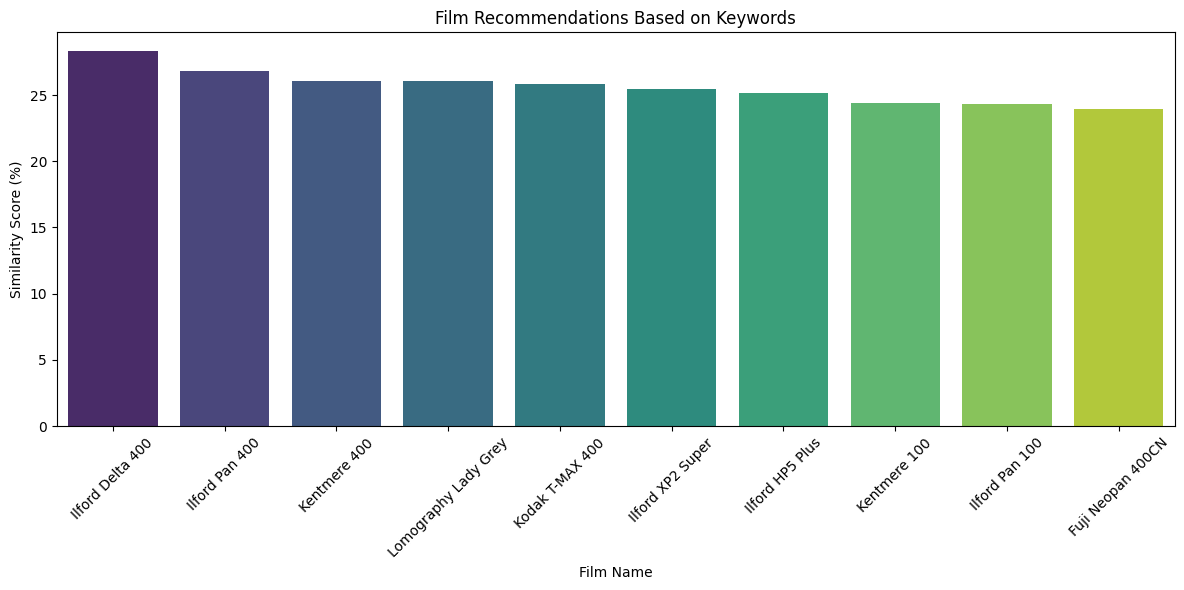

In [56]:
def generate_film_recommendations(film, keywords, description_similarities, numerical_similarities, bof_similarities):
    if isinstance(keywords, str):
        keywords = [keywords]
    
    # Create a combined condition for all keywords across relevant columns
    conditions = (
        film['Description'].str.contains('|'.join(keywords), case=False, na=False) |
        film['Film type'].str.contains('|'.join(keywords), case=False, na=False) |
        film['Film grain'].str.contains('|'.join(keywords), case=False, na=False) |  
        film['Film contrast'].str.contains('|'.join(keywords), case=False, na=False) | 
        film['Film hue'].str.contains('|'.join(keywords), case=False, na=False) |
        film['Film use cases'].str.contains('|'.join(keywords), case=False, na=False)
    )
    filtered_film_df = film[conditions]

    # Used LLM to assist with this code
    # Use our calculated cosine similarities for all of the data
    description_relevant_similarities = description_similarities.loc[filtered_film_df.index, filtered_film_df.index]
    numerical_relevant_similarities = numerical_similarities.loc[filtered_film_df.index, filtered_film_df.index]
    bof_relevant_similarities = bof_similarities.loc[filtered_film_df.index, filtered_film_df.index]

    # Concatenate the similarities
    combined_similarities = pd.concat([description_relevant_similarities, numerical_relevant_similarities, bof_relevant_similarities], axis=1)
    combined_scores = combined_similarities.sum(axis=1)
    
    # Used LLM to assist with this code
    # Get recommendations for top 10 most similar based on keyword description
    top_indices = np.argsort(combined_scores)[::-1][:10]
    recommended_films = filtered_film_df.iloc[top_indices]
    recommended_films['Similarity Score'] = combined_scores[top_indices].values

    return recommended_films

#Add your keywords below!
keywords = ['sports', 'black and white']
recommended_films = generate_film_recommendations(film, keywords, description_similarities, numerical_similarities, bof_similarities)
print(recommended_films.to_string(index=False))

# Display images for each recommended film
html_output = ''.join(f'<img src="{url}" style="width:100px; display:inline-block; margin:10px"/>' for url in recommended_films['Photo of the film'])
display(HTML(html_output))

# Plotting a bar graph by similarity
plt.figure(figsize=(12, 6))
sns.barplot(data=recommended_films, x='Film name', y='Similarity Score', palette='viridis')
plt.xticks(rotation=45)
plt.title('Film Recommendations Based on Keywords')
plt.ylabel('Similarity Score (%)')
plt.xlabel('Film Name')
plt.tight_layout()
plt.show()

### **References**: 
McCallum, L. (2024) Week 3 - Content Based Filtering, GitHub. Available at: https://git.arts.ac.uk/lmccallum/personalisation-23-24/blob/main/week-3-movies.ipynb (Accessed: 25 April 2024).

FilmTypes (no date). Available at :https://www.filmtypes.com/films (Accessed: 1 May 2024).


Broad, T. and Fiebrink, B. (2023) Week 4: Topic modelling nursery rhymes with Bag of Words features and Latent Dirichlet Allocation (LDA), GitHub. Available at: https://git.arts.ac.uk/tbroad/NLP-23-24/blob/main/Week-4-Search-and-topic-modeling/topic-modelling-bow-lda.ipynb (Accessed: 8 June 2024). 

Broad, T. and Fiebrink, B. (2023) Week 4: Topic modelling nursery rhymes with TF-IDF features and Latent Semantic Analysis (LSA), GitHub. Available at: https://git.arts.ac.uk/tbroad/NLP-23-24/blob/main/Week-4-Search-and-topic-modeling/topic-modelling-tfidf-lsa.ipynb (Accessed: 8 June 2024). 


### **LLM Disclaimer**

LLM was partially used throughout the project in order to de-bug code issues that arose with the notebook. You can see additional specific LLM Disclaimers throughout the notebook.